In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [3]:
from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import entropy as calculate_entropy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [4]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [25]:
datasize = 100
max_document_length = 256

index = -1
clean_docs = []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue

        clean_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

print(clean_docs[0])


apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watching around in a secluded spot etc have my key ready to open the door so i m


In [26]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [27]:
print(f"there are {len(clean_docs)} docs")

there are 400 docs


### count words

In [28]:
# mode = "tfidf"
# mode = "binary"
# mode = "normalize"
# mode = "binary-normalize"
mode = "pmi"

# initialize the count vectorizer
vectorizer = TfidfVectorizer() if mode == "tfidf" else CountVectorizer()

# fit it to dataset
train_docs, test_docs = train_test_split(clean_docs, test_size=.33, random_state=42)

vectorizer.fit(train_docs)
vocabulary = vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 2318


### Prepare Datatset

In [29]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()
test_doc_vectors = vectorizer.transform(test_docs).toarray()

if mode in ["binary-normalize", "binary", "pmi"]:
    train_doc_vectors = (train_doc_vectors > 0).astype(float)
    test_doc_vectors = (test_doc_vectors > 0).astype(float)
    
if mode == "normalize" or mode == "binary-normalize":
    train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
    test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_doc_vectors)} train_docs, {len(test_doc_vectors)} test docs")

268 train_docs, 132 test docs


### Word-Word Ratio

In [30]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = pd.DataFrame(train_doc_vectors, columns=vocabulary)

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))
p = pd.DataFrame((train_doc_vectors.sum(0) / len(train_doc_vectors)), columns=[0], index=vocabulary)[0]

for word in tqdm(vocabulary):
    pxy = word_doc_freqency[word_doc_freqency[word] == 1].sum(0) / len(train_doc_vectors)
    word_word_co[word] = sigmoid(np.nan_to_num(np.log2(pxy / (p[word] * p))))

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\christian\Documents\christian\work\python\cyberspace\semantic_segmentation\utils.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e**-x))



word_word_co has shape (2318, 2318)


In [31]:
# #reduce freq in doc to bin value of 1 or 0
# word_doc_freqency = pd.DataFrame(train_doc_vectors, columns=vocabulary)

# #the sum vertically of bin freq
# word_doc_total_frequency = word_doc_freqency.sum(0)

# word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
# word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))

# for word in tqdm(vocabulary):
#     word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
#     word_word_co[word] = ((word_word_frequency * word_frequency_norm) / word_doc_total_frequency).fillna(0)

# # word_word_co = (word_word_co.T / word_word_co.sum(1)).T
# print(f"word_word_co has shape {word_word_co.shape}")

In [32]:
word_word_co.head()

,000,013846,020359,077,0a,0x100,10,100,10k,12,...,yeah,year,yellow,yes,yet,yo,you,your,yuan,zip
000,0.99847,0.000000,0.000000,0.000000,0.000000,0.99847,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.592088,0.0,0.0,0.0
013846,0.00000,0.999686,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.876269,0.0,0.0,0.0
020359,0.00000,0.000000,0.999686,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
077,0.00000,0.000000,0.000000,0.999686,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0a,0.00000,0.000000,0.000000,0.000000,0.999686,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Calculate Word Trust ratio

In [33]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor = pd.DataFrame(data=gaussian2(word_entropy), columns=[0], index=vocabulary)[0]

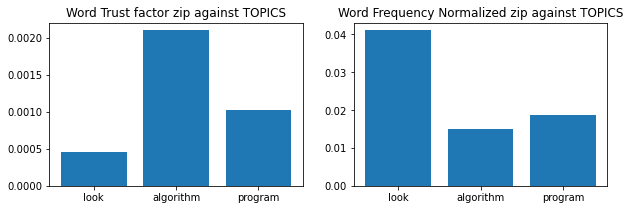

In [34]:
words = ["look", "algorithm", "program"]
# words = ["looking", "algorithm", "program", "the", "to", "of"]

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(f"Word Trust factor {word} against TOPICS")
ax1.bar(words, (word_trust_factor)[words])

ax2.set_title(f"Word Frequency Normalized {word} against TOPICS")
ax2.bar(words, word_frequency_norm[words])

plt.show()

### Observe word_word_co ratios

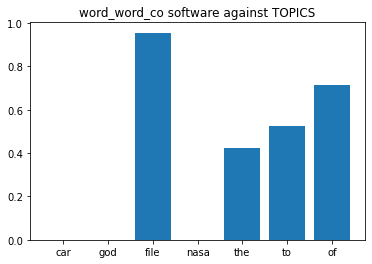

In [35]:
word = "software"
words = ["car", "god", "file", "nasa", "the", "to", "of"]

plt.title(f"word_word_co {word} against TOPICS")
plt.bar(words, word_word_co.loc[word][words])

plt.show()

In [36]:
word_word_co.loc[word].sort_values(ascending=False).head(15)

fashion         0.997685
generate        0.997685
analysis        0.997685
chad            0.997685
animation       0.997685
filmrecorder    0.997685
coreldraw       0.997685
cdr             0.997685
hava            0.997685
convert         0.997685
ge              0.997685
paint           0.997685
million         0.997685
containing      0.997685
analyze         0.997685
Name: software, dtype: float64

### Update word_word_co with gaussian entropy

In [221]:
# word_word_co = (word_word_co + (word_word_co * word_word_co.T)) * word_trust_factor
word_word_co = (word_word_co * word_trust_factor)
word_word_co = (word_word_co.T / word_word_co.sum(1)).T

### Observe word_word_co ratios

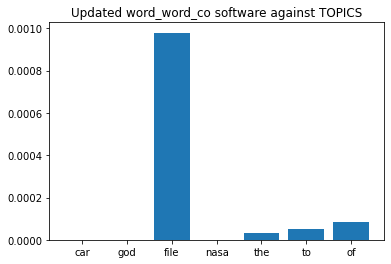

In [222]:
plt.title(f"Updated word_word_co {word} against TOPICS")
plt.bar(words, word_word_co.loc[word][words])

plt.show()

In [223]:
word_word_co.loc[word].sort_values(ascending=False).head(15)

bureau            0.032746
filmrecorder      0.032746
coreldraw         0.032746
bitmap            0.032746
cdr               0.032746
scodal            0.032746
convert           0.032746
recognises        0.032746
containing        0.032746
fashion           0.032588
ge                0.032588
million           0.032588
recommendation    0.032588
professional      0.032588
pattern           0.027876
Name: software, dtype: float64

In [224]:
word_entropy2 = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor2 = pd.DataFrame(data=gaussian2(word_entropy2), columns=[0], index=vocabulary)[0]

### Update word_word_co with word_word_co

In [225]:
# wwc = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

# for word in tqdm(vocabulary):
#     for other_word in vocabulary:
#         ratios = word_word_co.loc[word][other_word] * word_word_co.loc[other_word]
#         wwc.loc[word][ratios > wwc.loc[word]] = ratios[ratios > wwc.loc[word]]

# print(f"word_word_co has shape {word_word_co.shape}")

In [226]:
doc_word_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=word_doc_freqency.index)

for doc_index in tqdm(range(len(train_doc_vectors))):
    doc_word_distr.loc[doc_index] = (word_word_co * train_doc_vectors[0]).max(1)

print(f"doc_word_distr has shape {doc_word_distr.shape}")


doc_word_distr has shape (268, 2318)


In [230]:
doc_word_distr.shape

(268, 2318)

In [229]:
size = len(doc_word_distr)
dds = pd.DataFrame(cosine_similarity(doc_word_distr), columns=range(size), index=range(size))
dds.sum()

0      268.0
1      268.0
2      268.0
3      268.0
4      268.0
       ...  
263    268.0
264    268.0
265    268.0
266    268.0
267    268.0
Length: 268, dtype: float64

### Define Latent partitions

In [203]:
num_of_components = 4

pca = PCA(n_components=num_of_components)
result = pca.fit_transform(doc_word_distr.T)

word_word_distr_params = pd.DataFrame(data=result, columns=list(range(num_of_components)), index=vocabulary)

# word_word_distr_params = sigmoid(word_word_distr_params)
# word_word_distr_params = (word_word_distr_params.T / word_word_distr_params.sum(1)).T

# we = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_distr_params.T, base=2)), columns=[0], index=vocabulary)[0]
# wtf = pd.DataFrame(data=gaussian2(we), columns=[0], index=vocabulary)[0]
# word_word_distr_params = (word_word_distr_params.T * wtf).T

print(f"word_word_distr_params has shape {word_word_distr_params.shape}")

word_word_distr_params has shape (2318, 4)


In [209]:
word_word_distr_params = pd.DataFrame(data=np.array([doc_word_distr.mean(0), doc_word_distr.std(0)]).T, columns=["mean", "std"], index=vocabulary)

print(f"word_word_distr_params has shape {word_word_distr_params.shape}")

word_word_distr_params has shape (2318, 2)


In [210]:
word_word_distr_params.head()

,mean,std
000,0.0,0.0
013846,0.0,0.0
020359,0.0,0.0
077,0.0,0.0
0a,0.0,0.0


In [211]:
word_word_distr_params[2].sort_values(ascending=True).head(10)

KeyError: 2

In [212]:
# word_word_distr_params[1].sort_values(ascending=False).head(10)

### Use Kmeans to cluster the word_distr_params

In [241]:
num_of_topics = 4
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit()#, word_trust_factor)
kmeans_model.cluster_centers_

NameError: name 'word_doc_frequency' is not defined

In [233]:
dist = kmeans_model.transform(doc_word_distr)
# dist = normalize(dist, norm='l1', axis=0)
# dist = normalize(dist, norm='l1', axis=1)
print(f"dist has shape {dist.shape}")

dist has shape (268, 4)


In [234]:
dist

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [235]:
def get_top(topic):
    word_indices = dist[:, topic].argsort()
    print(word_word_distr_params.iloc[word_indices].head(20))
    
#     word_indices = np.where(kmeans_model.labels_ == topic)[0]
#     print(wtf.iloc[word_indices].sort_values(ascending=False).head(10))

In [236]:
get_top(0)

           mean  std
000         0.0  0.0
alignment   0.0  0.0
all         0.0  0.0
alleged     0.0  0.0
allen       0.0  0.0
alley       0.0  0.0
allow       0.0  0.0
allows      0.0  0.0
almost      0.0  0.0
alot        0.0  0.0
aloud       0.0  0.0
already     0.0  0.0
also        0.0  0.0
alt         0.0  0.0
always      0.0  0.0
am          0.0  0.0
amazing     0.0  0.0
america     0.0  0.0
amiga       0.0  0.0
ammended    0.0  0.0


In [237]:
get_top(1)

           mean  std
000         0.0  0.0
alignment   0.0  0.0
all         0.0  0.0
alleged     0.0  0.0
allen       0.0  0.0
alley       0.0  0.0
allow       0.0  0.0
allows      0.0  0.0
almost      0.0  0.0
alot        0.0  0.0
aloud       0.0  0.0
already     0.0  0.0
also        0.0  0.0
alt         0.0  0.0
always      0.0  0.0
am          0.0  0.0
amazing     0.0  0.0
america     0.0  0.0
amiga       0.0  0.0
ammended    0.0  0.0


In [238]:
get_top(2)

           mean  std
000         0.0  0.0
alignment   0.0  0.0
all         0.0  0.0
alleged     0.0  0.0
allen       0.0  0.0
alley       0.0  0.0
allow       0.0  0.0
allows      0.0  0.0
almost      0.0  0.0
alot        0.0  0.0
aloud       0.0  0.0
already     0.0  0.0
also        0.0  0.0
alt         0.0  0.0
always      0.0  0.0
am          0.0  0.0
amazing     0.0  0.0
america     0.0  0.0
amiga       0.0  0.0
ammended    0.0  0.0


In [239]:
get_top(3)

           mean  std
000         0.0  0.0
alignment   0.0  0.0
all         0.0  0.0
alleged     0.0  0.0
allen       0.0  0.0
alley       0.0  0.0
allow       0.0  0.0
allows      0.0  0.0
almost      0.0  0.0
alot        0.0  0.0
aloud       0.0  0.0
already     0.0  0.0
also        0.0  0.0
alt         0.0  0.0
always      0.0  0.0
am          0.0  0.0
amazing     0.0  0.0
america     0.0  0.0
amiga       0.0  0.0
ammended    0.0  0.0


### Evaluate Topic model with Train set

In [65]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 90.67%, 25 misclassified



### Evaluating Topic Model with test set

In [66]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 54.55%, avg-accuarcy = 72.61%, 60 misclassified



### Investigating Misclassification

In [89]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
#     break

              autos  religion  graphics     space
ve         0.000334  0.000191  0.001622  0.000000
sense      0.000426  0.001182  0.000000  0.000000
maybe      0.000000  0.000906  0.000605  0.000000
shot       0.000000  0.000677  0.000000  0.000371
that       0.000299  0.000251  0.000241  0.000251
kind       0.000000  0.000394  0.000588  0.000000
cheap      0.000000  0.000954  0.000000  0.000000
embarrass  0.000000  0.000954  0.000000  0.000000
fundies    0.000000  0.000954  0.000000  0.000000
josh       0.000000  0.000954  0.000000  0.000000
mood       0.000000  0.000954  0.000000  0.000000
mcdowell   0.000000  0.000954  0.000000  0.000000
be         0.000165  0.000224  0.000176  0.000203
of         0.000119  0.000248  0.000176  0.000181
to         0.000140  0.000208  0.000155  0.000176
okay       0.000000  0.000375  0.000293  0.000000
except     0.000307  0.000350  0.000000  0.000000
who        0.000148  0.000316  0.000030  0.000111
but        0.000055  0.000224  0.000197  0.000128


may       0.000021  0.000090  0.000056  0.000031
from phil g fraering pgf srl03 cacs usl edu right the profit caste be bless by god and may freely blare it presence in the even twilight
==> predicted_topic = religion, actual_topic = space 

            autos  religion  graphics     space
help     0.000000  0.000315  0.001873  0.000330
the      0.000425  0.000436  0.000395  0.000502
rest     0.000000  0.000886  0.000000  0.000424
shirt    0.000000  0.001130  0.000000  0.000000
night    0.000000  0.001130  0.000000  0.000000
delete   0.000000  0.001130  0.000000  0.000000
brown    0.000000  0.001130  0.000000  0.000000
of       0.000141  0.000293  0.000209  0.000215
out      0.000276  0.000259  0.000199  0.000120
in       0.000158  0.000150  0.000188  0.000167
can      0.000104  0.000085  0.000193  0.000155
about    0.000169  0.000113  0.000081  0.000073
anybody  0.000088  0.000057  0.000209  0.000041
find     0.000124  0.000046  0.000141  0.000030
rest delete can anybody out in a p h he

### Using Latent Dirichlet Allocation

In [68]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 100.00%, test_accuarcy = 62.88%, avg-accuarcy = 81.44%
